# Install packages

Mount your google drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Setup working directory:

In [ ]:
import sys
sys.path.insert(0,"/content/drive/My Drive/workshop_demo") # please change to your working directory

We used a simulated data from R. Install package for reading in R data:

In [ ]:
!pip3 install pyreadr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 20.2 MB/s eta 0:00:00


Import packages:

In [ ]:
import pyreadr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import tensorflow.keras.backend as tfkb
from tensorflow.keras import layers, regularizers, Model, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
import matplotlib.pylab as plt
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
import numpy as np
import multiprocessing

Import function for Cox partial likelihood with Efron's approximation and function for calculating baseline hazards:

In [ ]:
from fun_util import loss_lik_efron, base_efron

Install survival analysis package:

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=4af069616f41250f33a53ef5f9bcc0d89a61ce489fa8cc2b137609ce88aa07b9
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


Import functions for Kaplan Meier estimator:

In [ ]:
from lifelines import KaplanMeierFitter

# Data preparation

Specify the time of interest, training and test data:

In [ ]:
time_interest = np.array(12) # time of interest=12
name_of_train_data='/content/drive/My Drive/workshop_demo/train1.RData' # please change to your path that contains train1.RData
name_of_test_data='/content/drive/My Drive/workshop_demo/test.RData' # please change to your path that contains test.RData

TrainData = pyreadr.read_r(name_of_train_data)['train1']
TestData = pyreadr.read_r(name_of_test_data)['testdat']

TrainData.dropna(axis = 0, how = 'any', inplace = True)
TestData.dropna(axis = 0, how = 'any', inplace = True)

In [ ]:
TrainData.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,Treatment,Time,Event
0,0.876149,-0.049222,0.153702,0.038154,-0.055201,-0.255438,0.627585,0.0,0.0,0.0,0.0,9.025655,1.0
1,0.387336,-0.203499,0.352920,-0.435417,0.452223,0.362317,-0.365849,0.0,0.0,0.0,0.0,9.511525,0.0
2,-0.220069,0.050796,-0.395977,-0.718578,0.016812,-0.124704,0.144633,0.0,1.0,1.0,1.0,21.284439,1.0
3,0.107290,-0.418507,0.101572,0.244165,0.012389,-0.337446,0.519115,0.0,0.0,0.0,0.0,18.554036,1.0
4,0.034529,1.073348,0.083804,0.987468,0.358705,0.031136,-0.036031,1.0,1.0,0.0,1.0,5.210649,0.0
5,0.332776,-0.406414,-0.019982,0.448290,0.402953,0.323040,0.894975,1.0,1.0,1.0,0.0,8.692751,0.0
6,-0.557824,0.043133,-0.259070,-0.079533,-0.625972,-0.393620,-0.086564,1.0,1.0,1.0,0.0,17.911085,1.0
7,0.390970,0.726353,0.189874,0.314449,-0.496994,0.373875,-0.281691,1.0,1.0,0.0,1.0,12.615614,0.0
8,0.256543,0.882451,0.350935,0.191797,0.302960,0.074133,0.029289,0.0,1.0,0.0,1.0,28.694966,1.0
9,-0.191978,0.134047,0.036077,0.025446,-0.194071,0.327366,0.310633,1.0,0.0,0.0,0.0,14.883610,1.0


In [ ]:
# Prepare data for running X-learner
data = TrainData

data1 = TrainData[(TrainData['Treatment']==1)]
data0 = TrainData[(TrainData['Treatment']==0)]

# prepare training data for treatment group=1
x_dat1 = tf.convert_to_tensor(data1.drop(['Treatment',"Time","Event"],axis=1))
y_dat1 = tf.convert_to_tensor(data1[["Time","Event"]])

# prepare training data for treatment group=0
x_dat0 = tf.convert_to_tensor(data0.drop(['Treatment',"Time","Event"],axis=1))
y_dat0 = tf.convert_to_tensor(data0[["Time","Event"]])

# **X-learner**

Calculate IPCW using KM:

In [ ]:
# model censoring probability using KM
U = np.minimum(data['Time'], time_interest)

k_folds=4

fold_id = np.random.choice(np.repeat(np.arange(1, k_folds + 1), len(data)), len(data))
C_hat = np.full(len(fold_id), np.nan)

for z in range(1, k_folds + 1):
    censored_data = data[fold_id != z]
    c_fit = KaplanMeierFitter().fit(durations=censored_data['Time'], event_observed=1 - censored_data['Event'])
    kmc = c_fit.survival_function_at_times(U[fold_id == z])
    C_hat[fold_id == z] = kmc.values[0]

Fit Cox NN using Cox partial likelihood with Efron's approximation on each treatment arm

In [ ]:
### set up DNN parameters ###
num_nodes = 30             # number of nodes per hidden layer
string_activation = "selu" # activation function
num_l1 = 0.1               # L1 penalty
num_lr = 0.01              # learning rate
num_epoch = 50            # number of epoches for optimization
batch_size = 50            # number of batch size for optimization

In [ ]:
#-------------------- Fit DNNsurv for treatment group=1 (~4min) ----------------------#
tf.config.run_functions_eagerly(True)
#clear the previous model
tfkb.clear_session()

# define the keras model
model1 = Sequential()
model1.add(Dense(num_nodes, input_dim=x_dat1.shape[1], activation=string_activation,kernel_regularizer=regularizers.l1(num_l1)))
model1.add(Dense(num_nodes, activation=string_activation,kernel_regularizer=regularizers.l1(num_l1)))
model1.add(Dense(1, activation=string_activation))

# compile the keras model
opt = RMSprop(learning_rate = num_lr)
model1.compile(
    loss      = loss_lik_efron,
    optimizer = opt,
    metrics   = None,
    run_eagerly=True
)

# fit the keras model on the training set
history1=model1.fit(x_dat1, y_dat1,
                    epochs=num_epoch,
                    batch_size=batch_size,
                    verbose = 1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 404ms/step - loss: 120.3540
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - loss: 112.4992
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 536ms/step - loss: 112.4938
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 396ms/step - loss: 108.4437
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 457ms/step - loss: 109.7911
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 411ms/step - loss: 97.8031
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 466ms/step - loss: 100.8906
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - loss: 97.0306
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - loss: 98.5897
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 450ms/step - loss: 96.0270
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/step - loss: 95.1800
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - loss: 97.4659
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 507ms/step - loss: 93.0395
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 430ms/step - loss: 95.0888
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/

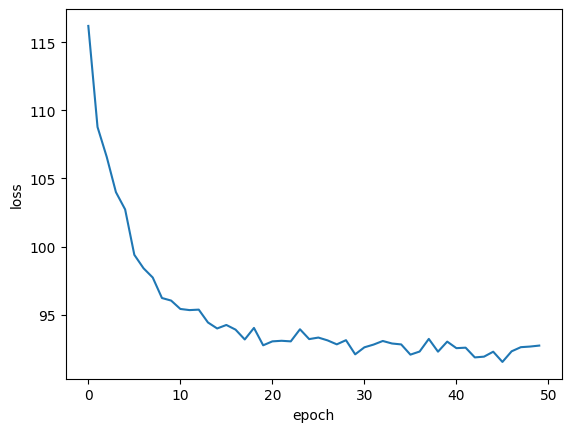

In [ ]:
 plt.plot(history1.history['loss'])
 plt.xlabel('epoch')
 plt.ylabel('loss')
 plt.show()

In [ ]:
#-------------------- Fit DNNsurv for treatment group=0 ----------------------#
#clear the previous model
tfkb.clear_session()

# define the keras model
model0 = Sequential()
model0.add(Dense(num_nodes, input_dim=x_dat0.shape[1], activation='selu',kernel_regularizer=regularizers.l1(num_l1)))
model0.add(Dense(num_nodes, activation='selu',kernel_regularizer=regularizers.l1(num_l1)))
model0.add(Dense(1, activation='selu'))

# compile the keras model
opt = RMSprop(learning_rate = num_lr)
model0.compile(
        loss      = loss_lik_efron,
        optimizer = opt,
        metrics   = None,
        run_eagerly=True
)

# fit the keras model on the training set
history0=model0.fit(x_dat0, y_dat0,
                    epochs=num_epoch,
                    batch_size=batch_size,
                    verbose = 1)

tfkb.clear_session()

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 542ms/step - loss: 138.5110
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 475ms/step - loss: 129.1549
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - loss: 123.4959
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 545ms/step - loss: 123.3634
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 420ms/step - loss: 120.2532
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 557ms/step - loss: 115.0390
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 422ms/step - loss: 118.0959
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 487ms/step - loss: 113.9648
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 436ms/step - loss: 114.3015
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 563ms/step - loss: 114.5814
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 449ms/step - loss: 112.7089
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 510ms/step - loss: 114.3369
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 480ms/step - loss: 111.0269
Epoch 14/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 434ms/step - loss: 115.6166
Epoch 15/50
11/11 ━━━━━━━━━━━━━━━━━━━━

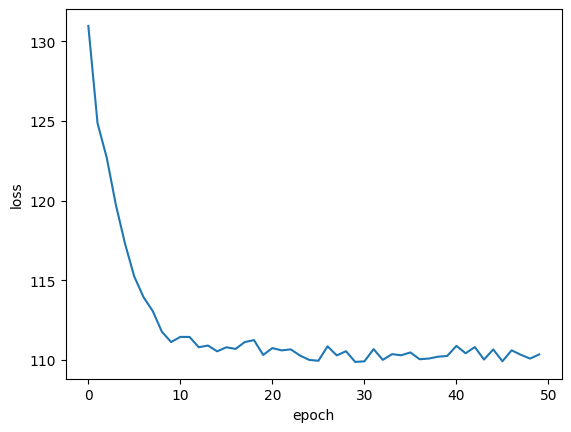

In [ ]:
# plot loss
plt.plot(history0.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Predict counterfactual survival probability for each treatment arm:

In [ ]:
## predict prognostic index
# for trt group
y_dat_pred01 = model0.predict(x_dat1) # predicted counterfactual prognostic score: trt data, ctrl model
y_dat_pred11 = model1.predict(x_dat1) # prognostic score corresponding to trt: trt data, trt model
# for control gr
y_dat_pred00 = model0.predict(x_dat0) # prognostic score corresponding to ctrl: ctrl data, plug in ctrl model
y_dat_pred10 = model1.predict(x_dat0) # predicted counterfactual prognostic score: ctrl data, plug in trt model

# baseline cumulative hazard for the model of treatment group=1
baseline1 = base_efron(y_test=y_dat1, y_test_pred=y_dat_pred11)
Lambda_t1 = baseline1['cumhazard'][np.max(np.where(baseline1['time'] <= time_interest))]

# baseline cumulative hazard for the model of treatment group=0
baseline0 = base_efron(y_test=y_dat0, y_test_pred=y_dat_pred00)
Lambda_t0 = baseline0['cumhazard'][np.max(np.where(baseline0['time'] <= time_interest))]

# Predict counterfactual survival probability
S_x01 = np.exp(-1 * np.outer(np.exp(y_dat_pred01),Lambda_t0)) # y_dat_pred01: predicted counterfactual for trt group subjects, Lambda_t0: baseline cumulative hazard for ctrl group hazard function
S_x10 = np.exp(-1 * np.outer(np.exp(y_dat_pred10),Lambda_t1)) # y_dat_pred10: predicted counterfactual for ctrl group subjects, Lambda_t1: baseline cumulative hazard for trt group hazard function

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Calculate $Y^*_1$ and $Y^*_0$:

In [ ]:
# calculate Y* for those whose I(T>t*) can be defined.
data0['Surv'] = np.where((data0['Time'] >= time_interest), 1,
                         np.where((data0['Time'] < time_interest) & (data0['Event'] == 1), 0, np.nan))

data1['Surv'] = np.where((data1['Time'] >= time_interest), 1,
                         np.where((data1['Time'] < time_interest) & (data1['Event'] == 1), 0, np.nan))


<ipython-input-20-b2ab067504b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data0['Surv'] = np.where((data0['Time'] >= time_interest), 1,
<ipython-input-20-b2ab067504b4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Surv'] = np.where((data1['Time'] >= time_interest), 1,


In [ ]:
# Extracting indices for Treatment==1 and Treatment==0
idx_trt = np.where(data['Treatment'] == 1)[0]
idx_ctrl = np.where(data['Treatment'] == 0)[0]

# Extracting C_hat for Treatment==1 and Treatment==0
C_hat_trt = C_hat[idx_trt]
C_hat_ctrl = C_hat[idx_ctrl]

# Extracting C_hat for Treatment==1 (censored)
C_hat_trt_cen = C_hat_trt[~np.isnan(data1['Surv'])]
# Extracting C_hat for Treatment==0 (censored)
C_hat_ctrl_cen = C_hat_ctrl[~np.isnan(data0['Surv'])]

In [ ]:
# Y^*_1
s1 = np.squeeze(S_x01)
mask_s1 = data1['Surv'].notna()
d1_full = data1['Surv'] - s1
d1 = d1_full[mask_s1]
#d1 = data1['Surv'][~np.isnan(data1['Surv'])] - s1[~np.isnan(data1['Surv'])]

In [37]:
mask_s1.shape-mask_s1.sum() # 89 out of 491 (18%) subjects do not have indicator function defined in trt group

array([89])

In [ ]:
# Y^*_0
s0 = np.squeeze(S_x10)
mask_s0 = data0['Surv'].notna()
d0_full = s0 - data0['Surv']
d0 = d0_full[mask_s0]
d0 = s0[~np.isnan(data0['Surv'])] - data0['Surv'][~np.isnan(data0['Surv'])]

In [38]:
mask_s0.shape-mask_s0.sum() # 76 out of 491 (18%) subjects do not have indicator function defined in trt group

array([76])

Arm-specific regression to estimate CATE (using grandient boosting as an example here):



In [ ]:
# IPCW
sample_weights_d0 = 1 / C_hat_ctrl_cen
sample_weights_d1 = 1 / C_hat_trt_cen

In [ ]:
# Control arm
params = {
    'n_estimators': 1000,
    'max_depth': 6,
    'min_samples_leaf': round(959/100),
    'subsample': 0.5,
    'loss': 'ls'
}

reg0 = GradientBoostingRegressor(
       loss='squared_error',   # replaces 'ls'
       learning_rate=0.1,      # (or whatever you were using)
       n_estimators=100,       # adjust as needed
       max_depth=3,            # etc.
       random_state=42
)

cols = ["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10"]
mask0 = ~np.isnan(data0['Surv'].to_numpy())
data0_reg = data0.loc[mask0,cols]
reg0.fit(data0_reg, d0, sample_weight=sample_weights_d0)
predictiond0 = reg0.predict(TestData[cols])

In [ ]:
# trt arm
reg1 = GradientBoostingRegressor(
       loss='squared_error',   # replaces 'ls'
       learning_rate=0.1,      # (or whatever you were using)
       n_estimators=100,       # adjust as needed
       max_depth=3,            # etc.
       random_state=42
)

cols = ["V1","V2","V3","V4","V5","V6","V7","V8","V9","V10"]
mask1 = ~np.isnan(data1['Surv'].to_numpy())
data1_reg = data1.loc[mask1,cols]
reg1.fit(data1_reg, d1, sample_weight=sample_weights_d1)
predictiond1 = reg1.predict(TestData[cols]) # plug in every subject

Fit propensity model of treatment assignment (using random forests here as an example):

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=1000,min_samples_leaf=5,max_features=1/3)
rf.fit(TrainData[cols],TrainData['Treatment'])
pred = rf.predict_proba(TestData[cols]) # predicted propensity score on test data

Final CATE estimator:

In [ ]:
preddiff = pred[:,0]*predictiond0 + pred[:,1]*predictiond1
#predtrue = np.column_stack((preddiff, TestData['true.diff'].to_numpy()))

Distribution of predicted CATEs:

(array([  5.,   4.,  19.,  33.,  50.,  62.,  70.,  85., 128., 169., 230.,
        373., 481., 514., 545., 618., 697., 777., 866., 867., 800., 756.,
        602., 478., 379., 228., 104.,  46.,  11.,   3.]),
 array([-0.93260879, -0.87377102, -0.81493325, -0.75609548, -0.69725771,
        -0.63841994, -0.57958217, -0.5207444 , -0.46190663, -0.40306886,
        -0.3442311 , -0.28539333, -0.22655556, -0.16771779, -0.10888002,
        -0.05004225,  0.00879552,  0.06763329,  0.12647106,  0.18530883,
         0.2441466 ,  0.30298437,  0.36182214,  0.42065991,  0.47949768,
         0.53833545,  0.59717321,  0.65601098,  0.71484875,  0.77368652,
         0.83252429]),
 <BarContainer object of 30 artists>)

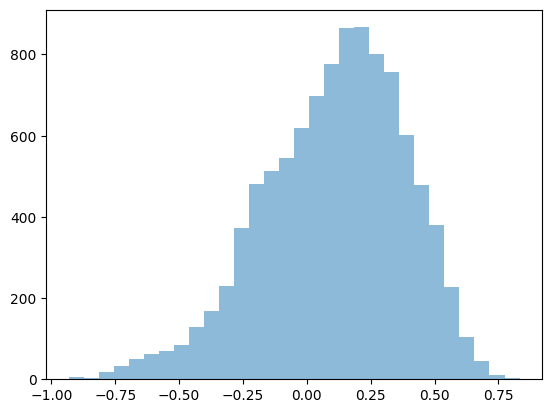

In [ ]:
plt.hist(preddiff, bins=30, alpha=0.5, label='Predicted')